Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.


# Lab 3: ES

## Task

Write agents able to play [_Nim_](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., _subtraction game_).

The goal of the game is to **avoid** taking the last object.

- Task2.1: An agent using fixed rules based on _nim-sum_ (i.e., an _expert system_)
- Task2.2: An agent using evolved rules using ES

## Instructions

- Create the directory `lab2` inside the course repo
- Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

- Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
- [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.


In [31]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
from functools import reduce


## The _Nim_ and _Nimply_ classes


In [32]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [33]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

- Class `Nim` is defined, with an initializer method `__init__`, three methods `__bool__`, `__str__`, and `nimming`, and a property `rows`.
- The `__init__` method takes two arguments: `num_rows` and `k` (with a default value of `None`), and initializes `self._rows` with a list of odd numbers and stores `k` in `self._k`.
- The `__bool__` method returns a boolean value indicating whether the sum of the numbers in `self._rows` is greater than 0.
- The `__str__` method returns a string representation of the `Nim` instance by joining the numbers in `self._rows` into a string enclosed in angle brackets.
- The `rows` property returns a tuple containing the numbers in `self._rows`.
- The `nimming` method takes a `Nimply` instance (or a tuple), unpacks it into `row` and `num_objects`, and performs two assertions. It subtracts `num_objects` from the number of objects in the specified row if both assertions pass.


## Sample (and silly) startegies


In [34]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice(
        [r for r, c in enumerate(state.rows) if c > 0]
    )  # select random non empty row
    num_objects = random.randint(
        1, state.rows[row]
    )  # select random number of objects to be removed from row
    return Nimply(
        row, num_objects
    )  # return new Nimply object for that row with updated number of objects

In [35]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)
    ]  # create list of all possible moves
    return Nimply(
        *max(possible_moves, key=lambda m: (-m[0], m[1]))
    )  # return Nimply object with maximum number of objects from lowest row

In [36]:
def adaptive1(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}  # set initial value for love_small

    if state.rows[0] <= 3:  # if lowest row has 3 or less objects
        genome["love_small"] = 0.9  # increase love_small
    elif state.rows[0] >= 7:  # if lowest row has 7 or more objects
        genome["love_small"] = 0.1  # decrease love_small

    row = min(
        range(len(state.rows)), key=lambda r: state.rows[r]
    )  # select row with lowest number of objects

    num_objects = int(
        genome["love_small"] * state.rows[row]
    )  # select number of objects to be removed from row

    return Nimply(
        row, num_objects
    )  # return Nimply object for that row with updated number of objects

In [37]:
import numpy as np


def nim_sum(state: Nim) -> int:
    """
    takes a `Nim` object and calculates the Nim-sum of the current game
    state by converting the counts of objects in the rows to binary, summing
    them, and taking the modulo 2 to obtain an integer Nim-sum
    """
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    """
    takes a `Nim` object and returns a dictionary with a single key,
    "possible_moves," which maps each possible move to its resulting Nim-sum. To
    calculate this, it iterates over all possible moves, makes a deep copy of
    the game state, applies the move to the copy, and calculates the Nim-sum of
    the resulting state
    """
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    """
    takes a `Nim` object and returns an optimal move by analyzing the
    current game state to get the Nim-sums of all possible moves. It selects
    moves that result in a non-zero Nim-sum, representing "winning" moves.
    If no such moves exist, it selects all moves and chooses one at random
    to return as the optimal move
    """

    # from archimedes-lab.org:

    # To win at Nim-game, always make a move, whenever possible, that leaves a
    # configuration with a ZERO “Nim sum”, that is with ZERO unpaired multiple(s)
    # of 4, 2 or 1. Otherwise, your opponent has the advantage, and you have to
    # depend on his/her committing an error in order to win.

    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply

## Oversimplified match

- The line `logging.getLogger().setLevel(logging.INFO)` sets the logging level to `INFO`, indicating that all logging messages with level `INFO` or higher will be displayed.

- The `strategy` tuple contains two functions, `optimal` and `pure_random`, which are used to determine the moves of the two players.

- The `while nim:` loop continues as long as the game is not over, meaning there are objects remaining in the game. Inside the loop, the current player's strategy function is invoked with the current game state to determine the next move (`ply = strategy[player](nim)`). This move is then applied to the game (`nim.nimming(ply)`), and both the game state and the move are logged. Finally, the current player is switched using `player = 1 - player`.

- After the loop, the final game state is logged, along with the player who won the game.


In [39]:
logging.getLogger().setLevel(logging.INFO)

strategy = (pure_random, pure_random)

res = []
for _ in range(1):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        print(strategy[player].__name__)
        print(nim.rows)
        print(ply)
        nim.nimming(ply)
        player = 1 - player
    res.append(player)
    # logging.info(f"status: Player {player} won using {strategy[player].__name__} startegy!")

print(np.array(res).mean())

<lambda>
(1, 3, 5, 7, 9)
Nimply(row=4, num_objects=5)
pure_random
(1, 3, 5, 7, 4)
Nimply(row=1, num_objects=3)
<lambda>
(1, 0, 5, 7, 4)
Nimply(row=0, num_objects=1)
pure_random
(0, 0, 5, 7, 4)
Nimply(row=3, num_objects=7)
<lambda>
(0, 0, 5, 0, 4)
Nimply(row=2, num_objects=5)
pure_random
(0, 0, 0, 0, 4)
Nimply(row=4, num_objects=2)
<lambda>
(0, 0, 0, 0, 2)
Nimply(row=4, num_objects=2)
1.0


# My strategy - Rule based evolutionary

The idea is to have a set of 'interesting' rules, but letting the agent understand if they are relevant or not (eg. can select only the rows that have a prime number of items).

The way that the optimisation is done is in the following way:
- The parameter optimised works as a threshold
- Next a random number in the range (0,1) is generated with an uniform probability
- If the number is below the threshold, then the rule is activated and will continue accordingly
    

In [40]:
# evolutionary params
POPULATION_SIZE = 100
MUTATION_RATE = 0.15
NUMBER_GENERATIONS = 300

# game params
NIM_DIM = 5
# number on matches in fitness
FITNESS_MATCHES = 100

VS_AGENT = pure_random


In [38]:
#Best Agent -> [1.         0.         0.         1.         0.71682349]
NUM_WEIGHTS = 5
def rule_based_strategy(nim, weights):
    #### CHOOSE ROWS
    pick_odd_threshold = weights[0]
    pick_primehaving_threshold = weights[1]

    pick_odd = np.random.rand() < pick_odd_threshold
    pick_prime = np.random.rand() < pick_primehaving_threshold

    take_rows = []
    feasible_rows = [True if x > 0 else False for i, x in enumerate(nim.rows)]
    take_rows.append(feasible_rows)
    if pick_odd:
        take_rows.append([True if x % 2 != 0 else False for i, x in enumerate(nim.rows)])
    if pick_prime:
        primes = [2,3,5,7,11,13,17,19]
        take_rows.append([True if x in primes else False for i, x in enumerate(nim.rows)])
    
    good_rows = reduce(np.logical_and, take_rows)
    good_rows_index = [i for i,x in enumerate(good_rows) if x == True]
    
    if good_rows_index == []:
        i_row = np.random.choice([i for i,x in enumerate(feasible_rows) if x == True])
    else:
        pick_random_threshold = weights[2]
        pick_min_threshold = weights[3]
        
        pick_random = np.random.rand() < pick_random_threshold
        if pick_random:
            i_row = np.random.choice(good_rows_index)
        else:
            pick_min = np.random.rand() < pick_min_threshold
            i_row = sorted(good_rows_index, key = lambda i: nim.rows[i], reverse=not(pick_min))[0]

    ### Pick Num Objects

    pick_all_threshold = weights[4]
    pick_all = np.random.rand() < pick_all_threshold
    how_many_objects = nim.rows[i_row] if pick_all else 1
    #how_many_perc = weights[4]
    #how_many_objects = max(1, round(how_many_perc*nim.rows[i_row]) )
    #print("ROWS:", nim.rows)
    #print("ROW:",i_row)
    #print("NUM:",nim.rows[i_row])

    return Nimply(i_row, how_many_objects)


In [41]:
def nim_match(agent1):
    strategy = (agent1, VS_AGENT)

    nim = Nim(5)
    player = random.randint(0, 1)
    number_moves = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player

    return 1 - player  # 1 if agent won, 0 if expert won


In [42]:
def fitness(agent, num_matches=FITNESS_MATCHES):
    # plays against expert by exectuing in order the moves of the agent and the expert agent
    # fitness is number of matches won by agent with max 10 matches
    runs = [nim_match(agent) for _ in range(num_matches)]
    return np.array(runs).mean()

In [43]:
def mutate(agent):
    # # swap two move strategies
    # if random.random() < MUTATION_RATE:
    #     swap_index1, swap_index2 = random.sample(range(MAX_NUMBER_MOVES), 2)
    #     agent[swap_index1], agent[swap_index2] = (
    #         agent[swap_index2],
    #         agent[swap_index1],
    #     )

    # change one move strategy to another strategy
    
    if random.random() < MUTATION_RATE:
        agent[np.random.randint(NUM_WEIGHTS)] += np.random.normal(loc=0.0, scale=0.2, size=1)


    return agent

def generate_random_agent():
    return mutate(np.array([0.5 for _ in range(NUM_WEIGHTS)]))
    #return mutate(np.random.rand(NUM_WEIGHTS))

In [44]:
def reproduce(agent1, agent2):
    # crossover
    # random split of the two agents and then concatenate them
    agent1_index = random.randint(0, NUM_WEIGHTS - 1)
    return np.concatenate((agent1[:agent1_index], agent2[agent1_index:]))
    #return (agent1 + agent2)/2

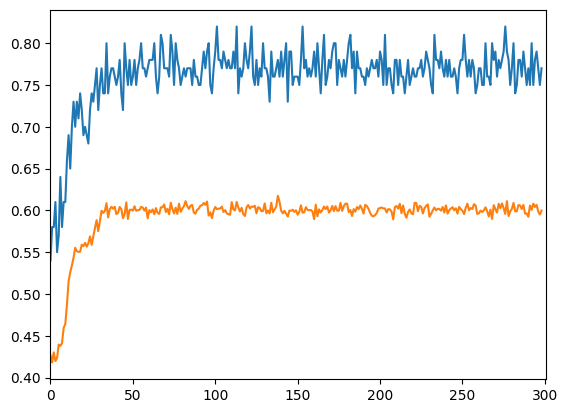

100%|██████████| 300/300 [10:55<00:00,  2.18s/it]


In [45]:
from tqdm import tqdm
from IPython. display import clear_output
import matplotlib.pyplot as plt
population = [generate_random_agent() for _ in range(POPULATION_SIZE)]
population = [np.clip(a, 0, 1) for a in population]

max_hist = []
mean_hist = []

for generation in tqdm(range(NUMBER_GENERATIONS)):
    # evaluate current generation
    fitness_scores = [fitness(lambda x: rule_based_strategy(x, weights=weights)) for weights in population]
    clear_output(wait=True)

    try:
        plt.plot(max_hist)
        plt.plot(mean_hist)
        plt.xlim(0, NUMBER_GENERATIONS+1)
        plt.show()
    except Exception as e:
        print(e)
        print("Nothing to show yet")

    # next gen parents
    num_parents = POPULATION_SIZE//4
    children = 2*(POPULATION_SIZE - num_parents)//3
    new_people = POPULATION_SIZE - num_parents - children

    selected_parents_i = np.argsort(fitness_scores)[::-1][:num_parents]
    selected_parents = [population[i] for i in selected_parents_i]
    #random.choices(
    #    population, weights=fitness_scores, k=num_parents
    #)

    # create next gen
    new_population = []
    max_hist.append(np.array(fitness_scores).max())
    mean_hist.append(np.array(fitness_scores).mean())
    
    for i in range(children):
        agent1 = random.choice(selected_parents)
        agent2 = random.choice(selected_parents)
        new_population.append(mutate(reproduce(agent1, agent2)))

    for i in range(num_parents): 
        new_population.append(selected_parents[i])

    for i in range(new_people):
        new_population.append(generate_random_agent())

    population = new_population
    population = [np.clip(a, 0, 1) for a in population]


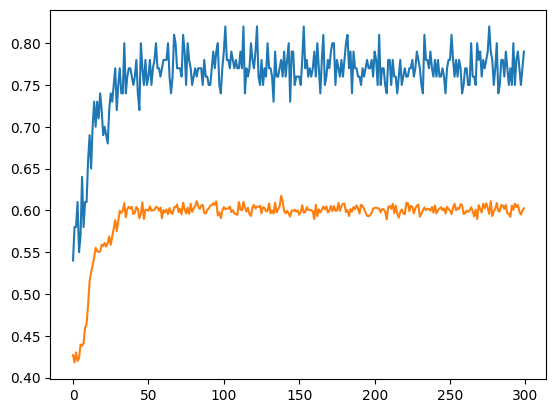

In [46]:
import matplotlib.pyplot as plt

plt.plot(max_hist)
plt.plot(mean_hist)
plt.show()

In [48]:
# print best agent
fitness_scores = [fitness(lambda x: rule_based_strategy(x, weights=weights), num_matches=1000) for weights in population]
i_best = np.argmax(fitness_scores)
best_agent_weights = population[i_best]
print()
print("Best Agent ->", best_agent_weights)
print("Fitness    ->", np.max(fitness_scores))


Best Agent -> [1.         0.         0.         0.92484106 0.        ]
Fitness    -> 0.691
